In [43]:
import numpy as np
import cv2
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.ndimage import gaussian_filter

In [44]:
# Normal distribution probability density function
def normal_dist_pdf(x, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x / sigma) ** 2)

In [45]:
# Create a 2D Gaussian kernel matrix
def gaussian_kernel_matrix(width, height, sigma):
    # Create grid of (x, y) coordinates
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)

    # Meshgrid to create coordinate matrix
    xv, yv = np.meshgrid(x, y)

    # Calculate center
    xc = (width - 1) / 2
    yc = (height - 1) / 2

    # Calculate distance from center for each point in the kernel
    dist = np.sqrt((xv - xc) ** 2 + (yv - yc) ** 2)

    # Apply normal distribution to the distances
    kernel = normal_dist_pdf(dist, sigma)

    # Normalize the kernel
    kernel = kernel / np.sum(kernel)

    return kernel

In [46]:
def pad_image(in_img, pad_width):
    num_row, num_col = in_img.shape
    
    # Initialize padded image
    img = np.zeros((num_row + pad_width * 2, num_col + pad_width * 2))
    
    # Copy original image to the center of the padded image
    img[pad_width:pad_width + num_row, pad_width:pad_width + num_col] = in_img
    
    # Padding top and bottom rows
    for c in range(num_col + pad_width * 2):
        for i in range(pad_width):
            img[i, c] = img[pad_width, c]
            img[pad_width + num_row + i, c] = img[pad_width + num_row - 1, c]
    
    # Padding left and right columns
    for r in range(num_row + pad_width * 2):
        for i in range(pad_width):
            img[r, i] = img[r, pad_width]
            img[r, pad_width + num_col + i] = img[r, pad_width + num_col - 1]
    
    return img

In [79]:
def convolve_2d(image, kernel):
    """Apply 2D convolution using a given kernel."""
    image_height, image_width = image.shape
    kernel_size = kernel.shape[0]
    pad_size = kernel_size // 2

    # Pad the image with zeros on the border
    padded_image = np.pad(image, pad_size, mode='reflect')

    # Initialize output image
    output_image = np.zeros_like(image)

    # Perform convolution
    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            output_image[i, j] = np.sum(region * kernel)

    return output_image

In [48]:
def downsample(image):
    return image[::2, ::2]

In [49]:
def gaussian_pyramid(image, num_layers, kernel_size=5, sigma=1.0):
    pyramid = [image]  # Start with the original image
    
    # Generate Gaussian kernel
    kernel = gaussian_kernel_matrix(kernel_size, kernel_size, sigma)
    
    # Create pyramid
    for _ in range(num_layers):
        # Apply smoothing using the convolve_2d function
        smoothed_image = convolve_2d(pyramid[-1], kernel)
        downsampled_image = downsample(smoothed_image)  # Downsample the image
        pyramid.append(downsampled_image)
    
    return pyramid

In [51]:
def compute_fourier_pyramid(image):
    # Split the image into RGB channels
    channels = [image[..., i] for i in range(image.shape[2])]
    fourier_pyramid = []

    for channel in channels:
        f_transform = np.fft.fftshift(np.fft.fft2(channel))
        magnitude_spectrum = np.log(np.abs(f_transform) + 1)
        fourier_pyramid.append(magnitude_spectrum)

    # Stack the channels back together
    combined_fourier = np.stack(fourier_pyramid, axis=-1)
    
    return combined_fourier

In [52]:
def nearest_power_of_2(n):
    return 2 ** int(np.ceil(np.log2(n)))

In [53]:
from scipy.ndimage import zoom


def resize_to_power_of_2(image):
    """Resize the image dimensions to the nearest power of 2."""
    height, width = image.shape[:2]

    # Compute nearest power of 2 for both dimensions
    new_height = nearest_power_of_2(height)
    new_width = nearest_power_of_2(width)

    # Compute the resizing factors for height and width
    height_factor = new_height / height
    width_factor = new_width / width

    # Use zoom to resize the image
    resized_image = zoom(image, (height_factor, width_factor))

    return resized_image

In [92]:
from skimage import io, color

image = io.imread('./data/task1and2_hybrid_pyramid/4_einstein.bmp')

image_gray = color.rgb2gray(image)

In [93]:
resized_image = resize_to_power_of_2(image_gray)

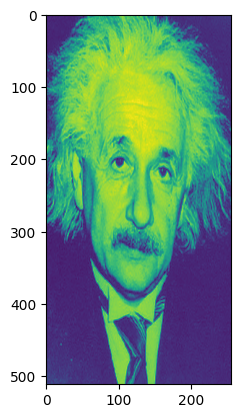

In [94]:
plt.imshow(resized_image)

In [84]:
import matplotlib.pyplot as plt

def plot_pyramids(gaussian_pyramid, fourier_gaussian):
    num_levels = len(gaussian_pyramid)
    
    fig, axs = plt.subplots(2, num_levels, figsize=(20, 20))
    
    pyramid_types = [
        ('Gaussian', gaussian_pyramid),
        ('Fourier', fourier_gaussian)
    ]
    
    for row, (title, pyramid) in enumerate(pyramid_types):
        axs[row, 0].set_ylabel(title, size='large')
        for level in range(num_levels):
            ax = axs[row, level]
            im = ax.imshow(pyramid[level], cmap='gray' if title == 'Gaussian' else 'jet')
            ax.axis('off')  # Hide axes
            if row == 0:
                ax.set_title(f'Level {level}')
    
    plt.tight_layout()
    plt.show()

In [85]:
def fourier_transform(pyramid):
    fourier_pyr = []
    for image in pyramid:
        f_transform = np.fft.fftshift(np.fft.fft2(image))
        magnitude_spectrum = np.log(np.abs(f_transform) + 1)
        fourier_pyr.append(magnitude_spectrum)
    return fourier_pyr

In [95]:
def process_image(image, num_layers=4, kernel_size=5, sigma=1.0):
    # Generate Gaussian pyramid
    gauss_pyramid = gaussian_pyramid(image, num_layers, kernel_size, sigma)
    
    # Compute Fourier pyramids
    fourier_gauss = fourier_transform(gauss_pyramid)
    
    # Plot all pyramids
    plot_pyramids(gauss_pyramid, fourier_gauss)

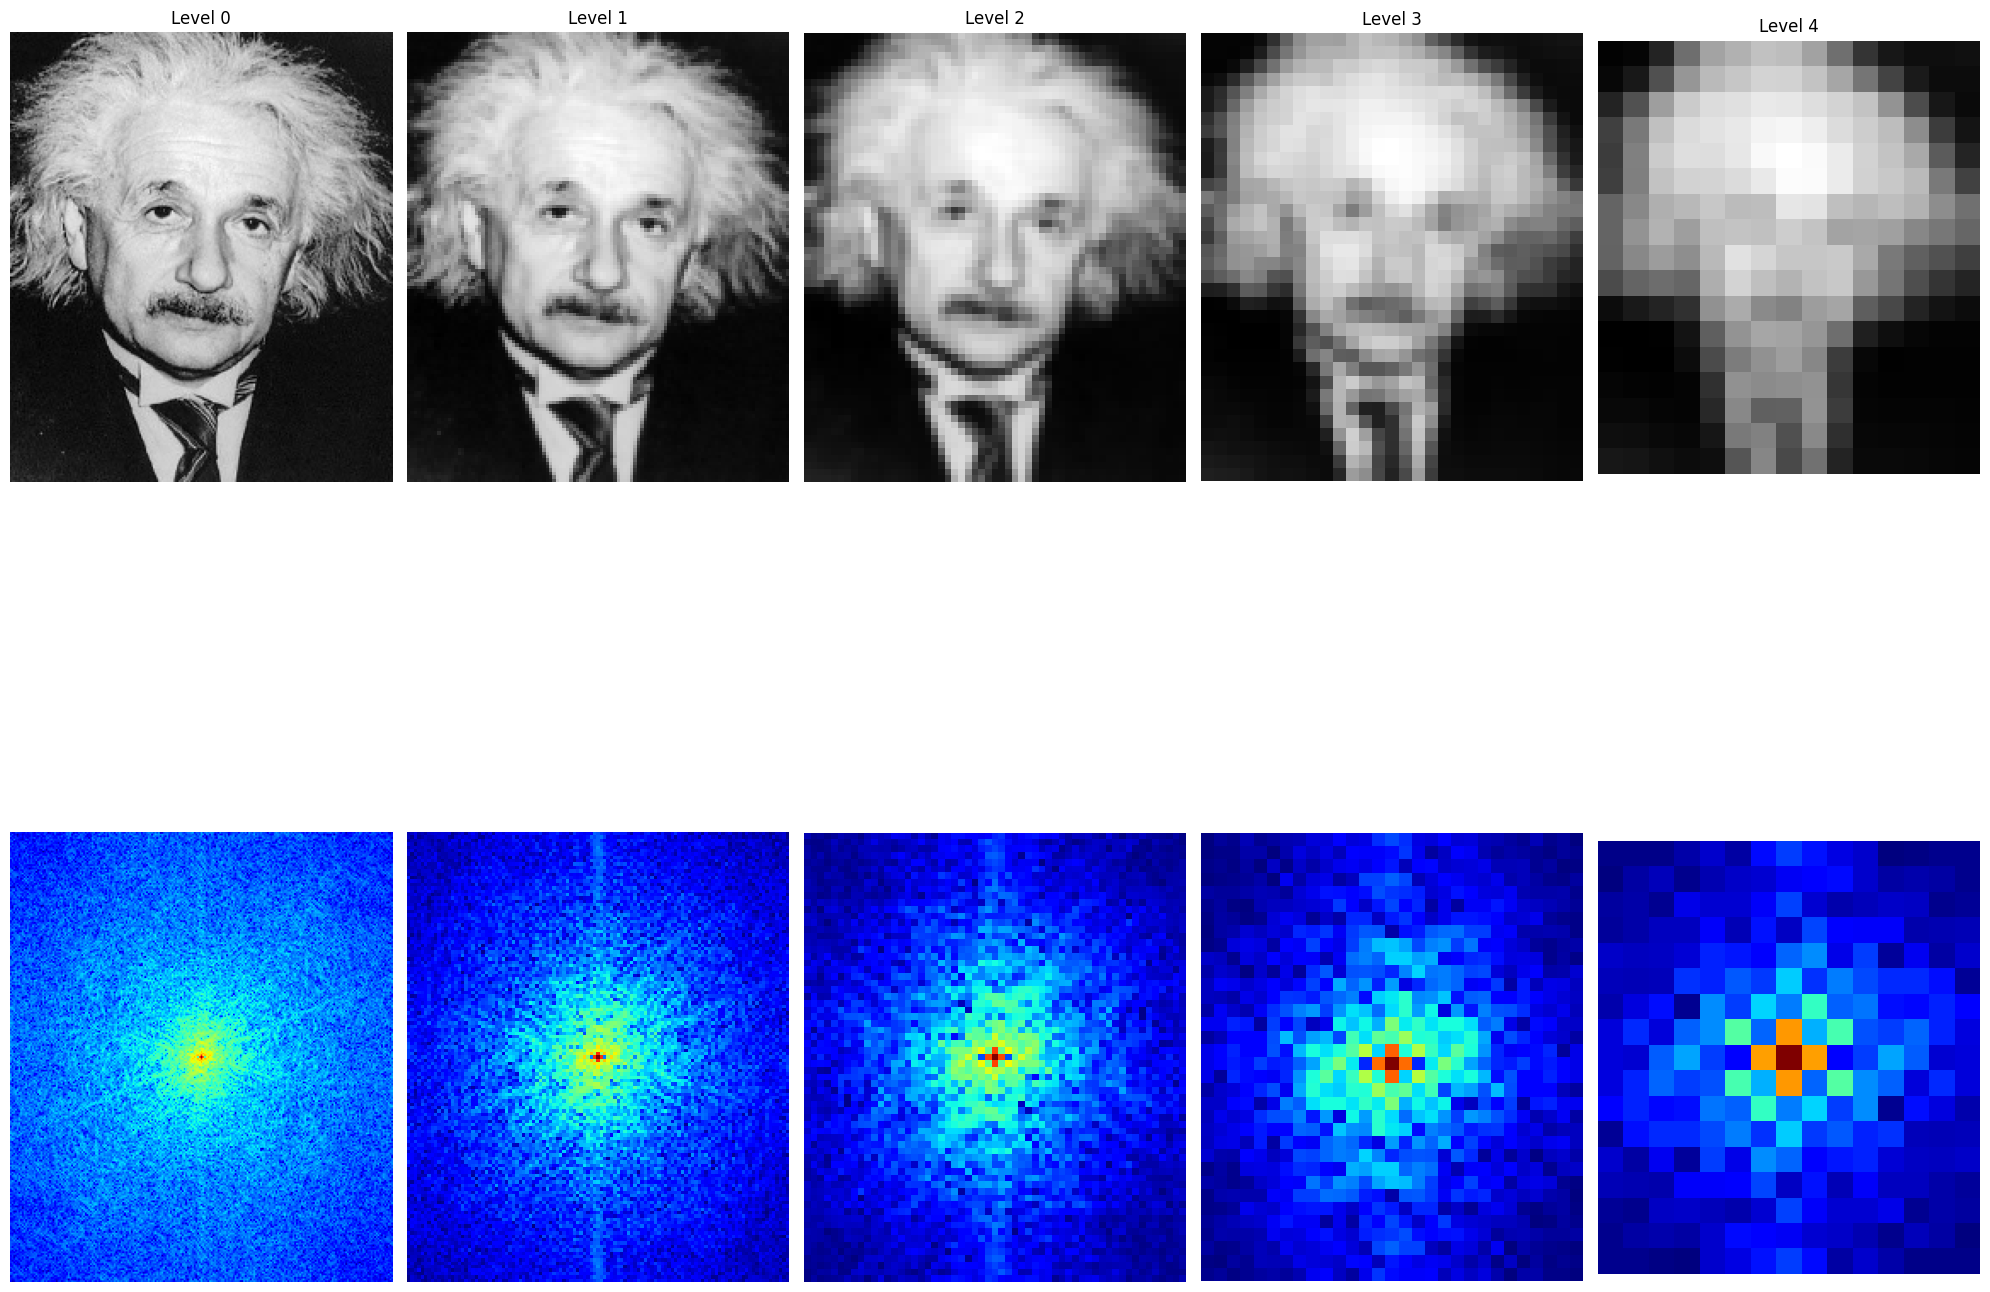

In [97]:
process_image(image_gray)

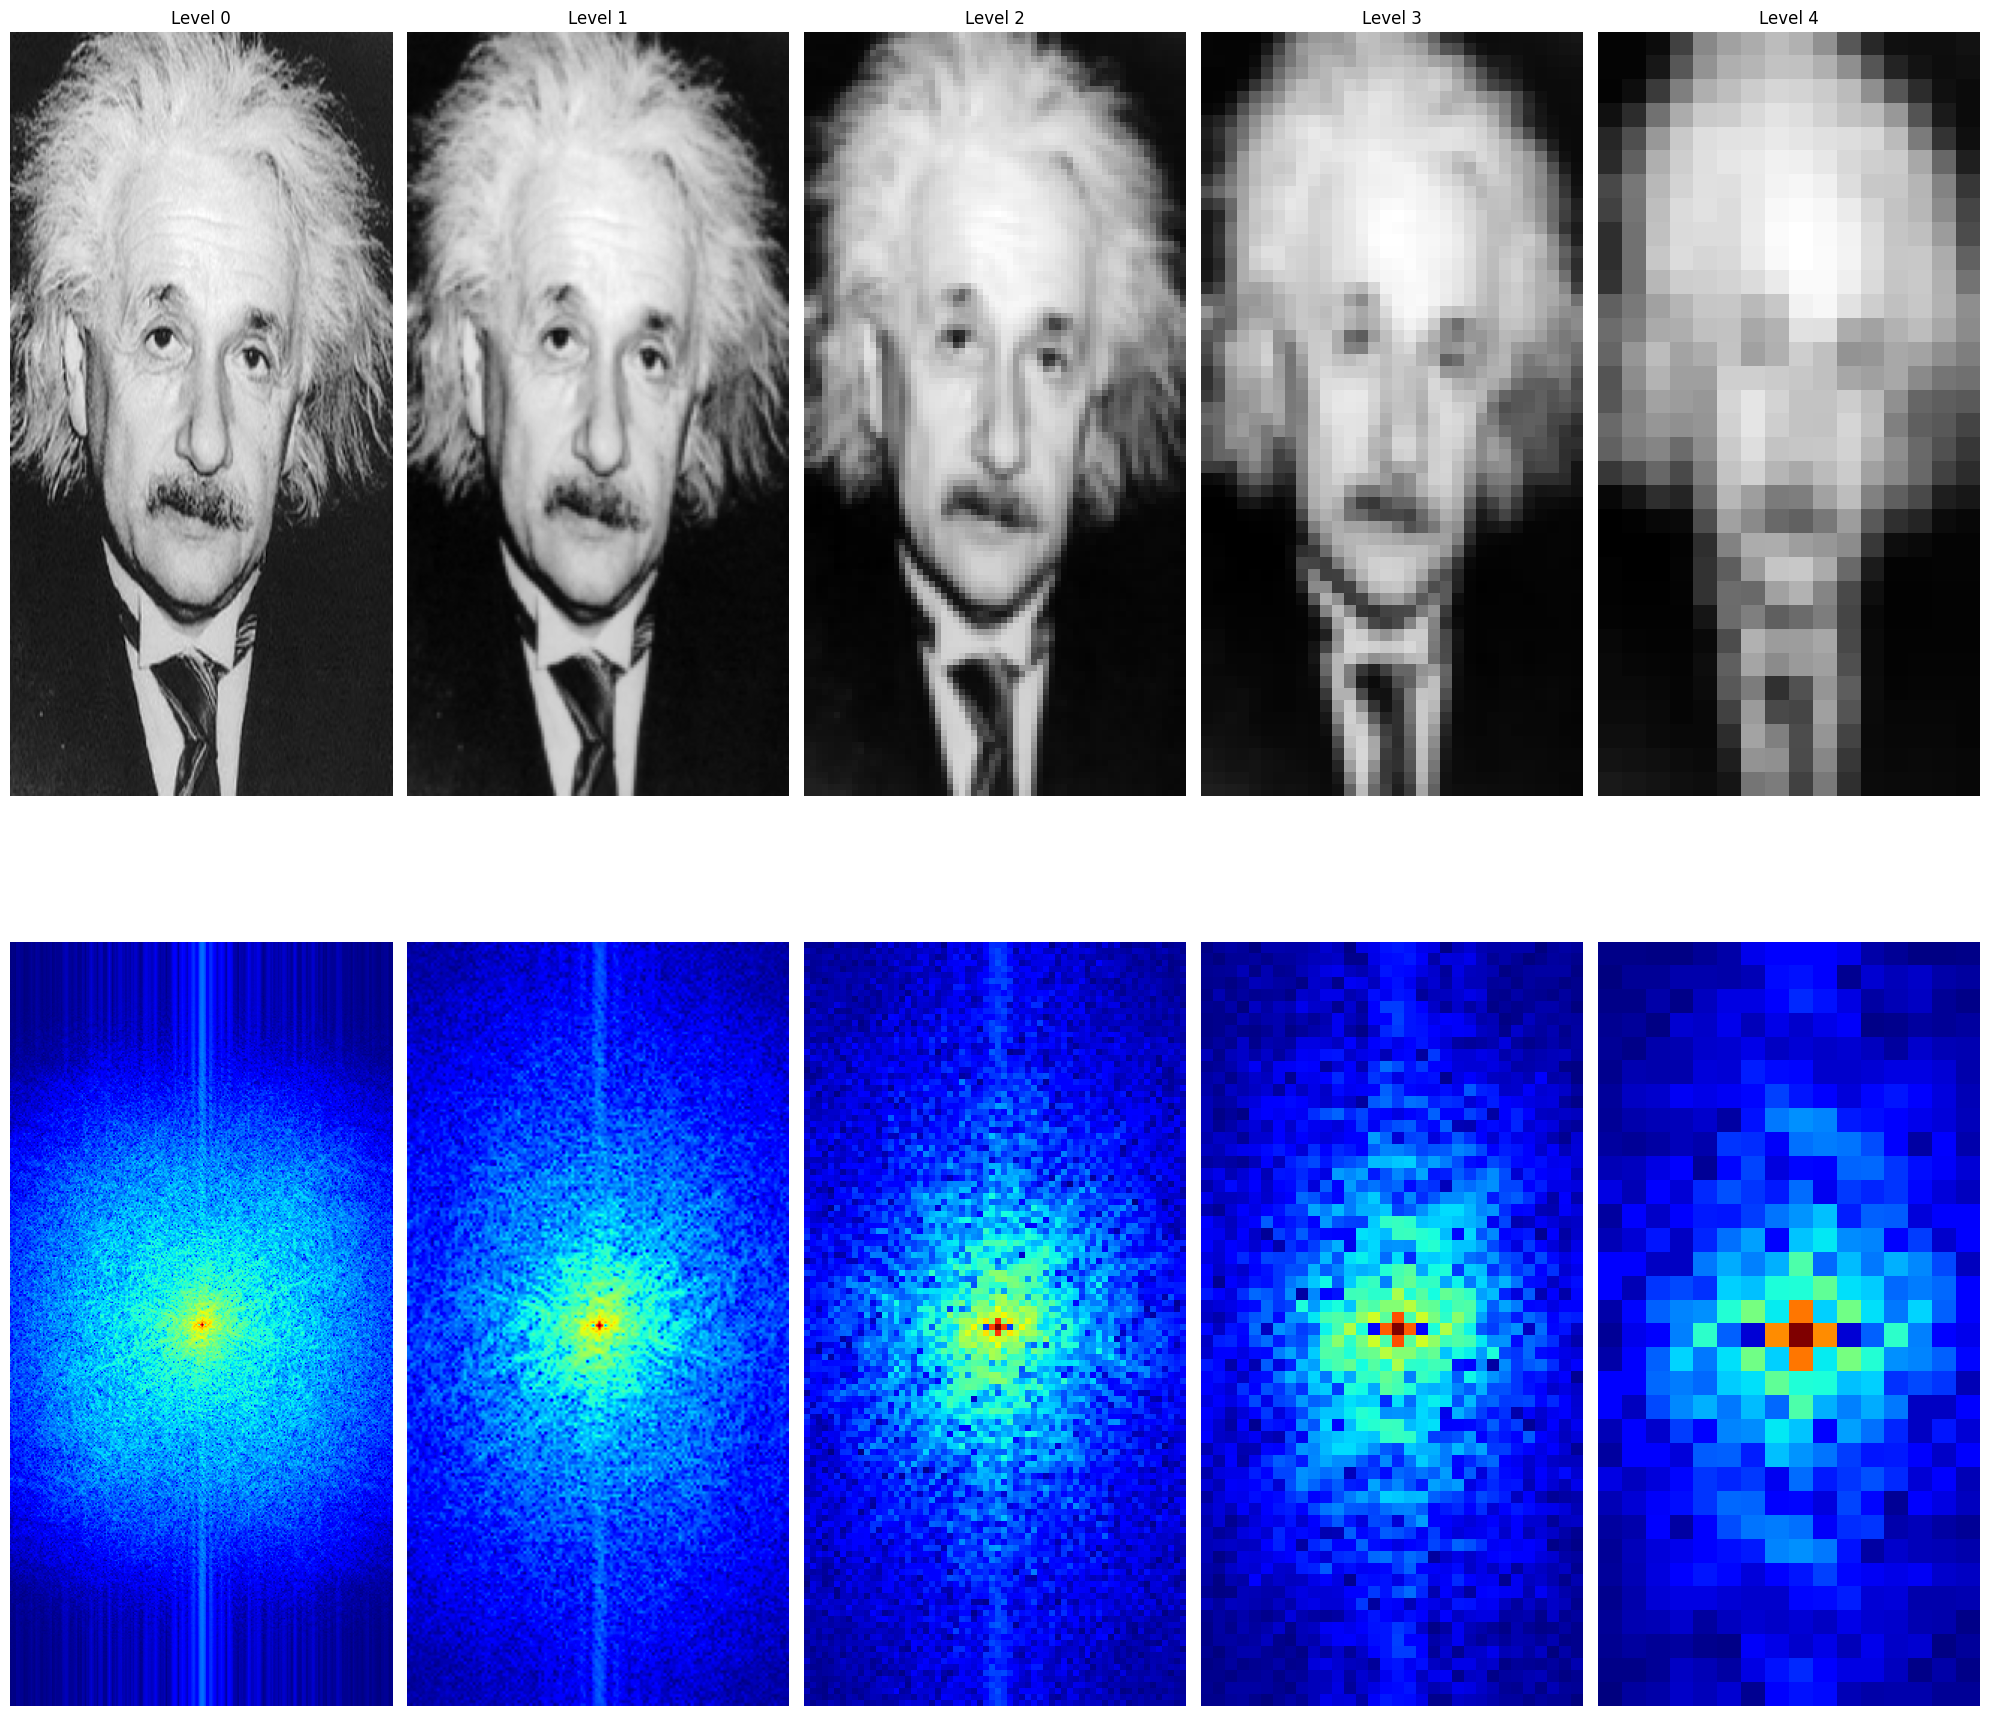

In [98]:
process_image(resized_image)